# Toxic Comment Classification Project
## Prepared by Furkan Küçük for DataBoss Analytics Job Application

NLP is a topic that dominated by deep learning. As the hand-crafted features are not sufficient enough to explain sentiments and nuance of a conversation, more complex feature extractors (like neural networks) emerged, and they are widely employed for NLP tasks.

In this notebook, I will explain how to approach an NLP project.

In [22]:
import pickle
import re
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler
from model_utils import ModelEngine
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
import copy
from tqdm.autonotebook import tqdm
# Disabling warnings. This should be used with great caution as this might be suppress neccessary warnings.
import warnings
warnings.filterwarnings("ignore")

### Word embeddings
Working with an appropriate word embeddings is essential for most of the NLP tasks. These embeddings enables models to make connections between words and help understand the context of a sentence. These word embeddings are being learned from various scraped text corpus with different kind of approaches. (like CBOW, skip-gram etc.) 

In this notebook, the Glove\[1] embeddings learned from Wikipedia will be used. The employed Glove embeddings includes 840 billion different embeddings inside. Words with uppercase, punctuations and denotations like \<EOS> or \<UNK> are included in this embeddings.
    
For the sake of saving some computation time, instead of plain embeddings obtained from official Stanford University resources, a pickled version is being used.

[1] https://nlp.stanford.edu/projects/glove/

Please run the cell below to load Glove embeddings into memory.

In [23]:
with open("data/glove.840B.300d.pkl", "rb") as file:
    glove_embeddings = pickle.load(file)

The "glove_embeddings" variable is an instance of dictionary. One can look into embeddings of the desired word with `glove_embeddings[word]` command.

In next step, loading the trainset is needed.

In [24]:
train_set = pd.read_csv("data/train.csv")
train_set.drop(columns="id", inplace=True)
train_set.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


As it can be seen above, the dataset consists of a comment text and 6 different labels. 

Since this dataset obtained from users, it's highly likely to have lots of punctuations, typos or even unknown characters as these users may be from different countries. Furthermore, even if there would be no mistakes made by users, a pre-process procedure would still might be needed. This pre-process steps should be done to reduce unknown words and to match as many words as possible to the dictionary, while preserving the context.

Machine learning is powered by the data, hence the most important part for a succesfull development is having an intuition of the given dataset.

Let's take a look at the class distribution.

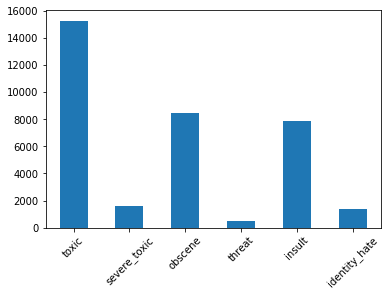

In [25]:
counts = train_set.iloc[:, 1:].sum()
counts.plot.bar(rot=45)

As it can be seen from the figure above, the class distribution of the given dataset is unbalanced. This information might be useful when we try to push a machine learning pipeline to learn correctly.

I would like to display the most frequent words for each class, however they can be disturbing rather than informative. So, that part will be skipped.

One may observe some correlations between toxic comments. For example:

In [26]:
capitals = train_set["comment_text"].apply(lambda x: sum([1 for char in x if char.isupper()]))
cols = train_set.columns[1:]
print([{col: capitals.corr(train_set[col])} for col in cols])

[{'toxic': 0.09117492294109422}, {'severe_toxic': 0.14341005690346098}, {'obscene': 0.08169052383797541}, {'threat': 0.033581380317309686}, {'insult': 0.07594470065619147}, {'identity_hate': 0.053576196218573416}]


There may seem to be some positive correlations with all classes with the usage of capitals. However, this intuition may or may not be useful since an entry can be long and have lots of sentences or names inside it. However, we can obtain a better intuition.

In [27]:
lengths = train_set["comment_text"].apply(lambda x: len(x))
lengths_vs_capitals = capitals / lengths
print([{col: lengths_vs_capitals.corr(train_set[col])} for col in cols])

[{'toxic': 0.2197005452460578}, {'severe_toxic': 0.16863805803863294}, {'obscene': 0.18137385574334297}, {'threat': 0.05535595072332992}, {'insult': 0.1693988277715875}, {'identity_hate': 0.09363198904381004}]


With the code above, we obtained a ratio between capitals and lengths. We can infer from this intuition that, toxic comments are tend to include more capitals comparing to their lengths.

General steps for text pre-processing are:
- Remove punctuations
- Translate all words to lowercase 
- Delete unknown words
- Stemming
- Lemmatization

However, applying these steps without any intuition may cause us to lose valuable information. For example; we inferred that, proportions of uppercase letters are a good indicator for if the comment is toxic or not. Furthermore, toxic comments tend to include some particular words. The existence of these words might be a valuable information, but stemming. The examples can be extended.

### How the pre-processing should be?
The main goal for preprocessing is closing the gap of unknown words between dataset and word embeddings. Luckily, Glove embeddings includes words with uppercases, has most of the punctuations and is large enough to cover a good proportion of the dataset.

Another purpose for pre-processing might be removing clutters or getting rid of words that does not matter much. However, syntax errors and typos are valuable informations for this dataset. Hence, it might be bad idea to removing clutters without further information.

Here are the preprocess part for the given dataset.

In [28]:
train_set["comment_text"] = train_set["comment_text"].apply(lambda x: x.replace("\r", "").replace("\n", " "))
punctuation = punctuation.replace("'", "")
train_set["comment_text"] = train_set["comment_text"].apply(lambda x: x.translate(
    str.maketrans({key: " {0} ".format(key) for key in punctuation})))
train_set["comment_text"] = train_set["comment_text"].apply(
    lambda x: x.replace(". . .", "...").replace(".  .  .", "..."))
train_set["comment_text"] = train_set["comment_text"].apply(lambda x: x.replace("'", "").replace("’", ""))

pattern = r"[^\w | {}]".format('!"#$%&(),.:;?')
train_set["comment_text"] = train_set["comment_text"].apply(lambda x: re.sub(pattern, "", x))

The code above runs these steps:
- Removes hidden characters like new line or tab.
- Removes apostrophe for getting dataset closer to word embeddings dictionary. (E.g. "didn't is not included in the dictionary. This should be corrected as "didnt", "did" - "n't" or "did not".
- Adds a space between words and punctuations.(For tokenizing step)
- Preserves 3 dots (...) and single dot (.) information
- Removes unknown or unimportant characters and punctuations.

The coverage of the embeddings for the spesific dataset can be inferred from the code below. Those outputs are not shown for reasons mentioned above. However, one can take a look at non-covered words by uncommenting the commented part.
Disclaimer: Disturbing words may appear.

In [29]:
words = list(train_set["comment_text"].apply(lambda x: x.split()))
full_word_list = [item for sublists in words for item in sublists]
word_counts = dict(Counter(full_word_list).most_common())

not_existing_in_embeddings = {}

for item in word_counts.items():
    if item[0] not in glove_embeddings.keys():
        not_existing_in_embeddings.update({item[0]: item[1]})
        
#[not_existing_in_embeddings][:20]

As we can see, most of the information is preserved by without applying general preprocessing approach.

One should split the sentence with white spaces to obtain embeddings from embeddings dictionary and feed them to neural networks model. The code below returns a "encodable" version of the given sentence by splitting it.

In [30]:
def tokenize(sentence: str) -> list:
    return sentence.split()

The code below implements a dataset implementation for particular dataset. It takes a dataframe which consists sentence and labels in it (like the train set). Please note that id column should be dropped before creating "TokenizedDataset" with a dataframe.

"TokenizedDataset" implementation will tokenize the given sentence, gets the partition according to preset maximum length (max_len variable), and gets the corresponding embedding vector for each token. Please note that if token could not be found in the embeddings dictionary, "UNK" value will be used instead.

Important note: max_len variable is being employed to change the maximum token number a "comment text" can include.

In [31]:
max_len = 300

class TokenizedDataset(Dataset):
    """
    PyTorch wrapper for preprocessed dataset.
    """
    def __init__(self, df: pd.DataFrame):
        """
        Init function
        :param df: Preprocessed dataframe
        """
        self.df = df

    def __len__(self):
        """
        Length of the data
        :return: length
        """
        return len(self.df)

    def __getitem__(self, item):
        """
        Get function for PyTorch
        :param item: item index
        :return: Processed embeddings and labels
        """
        if torch.is_tensor(item):
            item = item.data.numpy()

        sentence = self.df["comment_text"][item]
        tokenized_list = tokenize(sentence)
        if len(tokenized_list) >= max_len:
            tokenized_list = tokenized_list[:max_len]
        labels = self.df.iloc[item, 1:]
        embeddings = []
        if len(tokenized_list) == 0:
            embeddings.append(glove_embeddings["missing"])
        for tokenized_word in tokenized_list:
            try:
                embeddings.append(glove_embeddings[tokenized_word])
            except:
                embeddings.append(glove_embeddings["UNK"])

        embeddings = np.asarray(embeddings)
        labels = np.asarray(labels)

        return embeddings, labels

Length of tokenized sentences may vary across dataset. To satisfy the need of fixed-sized input, a zero padding collator is implemented below. The padding will be in "left padding" fashion. (E. g. 2,4,6 -> 0,0,2,4,6)

In [32]:
def pad_collator(batch):
    """
    Pads the given sentence to prepare for fixed size input. Padding is being done in left padding fashion.
    :param batch: batch
    :return: embeddings, targets
    """
    embeddings = [np.pad(item[0], [[max_len - len(item[0]), 0], [0, 0]]) for item in batch]
    embeddings = torch.from_numpy(np.asarray(embeddings))
    targets = torch.from_numpy(np.asarray([item[1].astype(np.float32) for item in batch]))
    return embeddings, targets

Before getting into model design part, one should decide on which metrics to use to evaluate models. ROC-AUC scoring is a widely adopted evaluation method for probability based scoring. However, as the data is highly imbalanced, precision-recall curves along with F1 scores would be a better evaluation.

#### Why not using the best validation loss as cross validation score?
F1 score is employed because it is a global metric, and remains the same for all model architectures. However, validation loss may vary as the loss function changes, and that makes it an unfair metric to use.

The standard approach used in this notebook for evaluating experimental models is 5-Fold Cross Validation scheme.

The evaluation of the each model will be as follows:
- Mean F1 scores for each class and each fold
- Mean F1 scores across folds
- Mean F1 score overall

In [33]:
def fold_generator(dataset: pd.DataFrame,
                   fold_number: int,
                   shuffle: bool = True):
    """
    Fold generator for non-sequential datasets
    :param dataset: NumPy array of dataset
    :param fold_number: Number of folds
    :return: Generated fold
    """
    if shuffle: # Same shuffled folds for every model by setting seed
        dataset = dataset.sample(frac=1, random_state=44).reset_index(drop=True)
    split_rate = len(dataset) // fold_number
    for n in range(fold_number):
        yield pd.concat([dataset.iloc[:split_rate * n, :].reset_index(drop=True),
                         dataset.iloc[split_rate * (n + 1):, :].reset_index(drop=True)]).reset_index(drop=True),\
              dataset.iloc[split_rate * n: split_rate * (n + 1), :].reset_index(drop=True)

def cross_validation(model_engine: ModelEngine,
                     trainset: pd.DataFrame,
                     fold_number: int = 5):
    """
    N-Fold cross validation helper function.
    :param model: Model engine
    :param trainset: Training dataset to be used for cross validation
    :param fold_number: Desired fold number
    :return: Averaged score for all folds
    """
    base_copy = copy.deepcopy(model_engine)
    model_scores = []
    generator = fold_generator(dataset=trainset, fold_number=fold_number)
    for index, (train, validation) in enumerate(tqdm(generator, total=fold_number, desc="Fold")):
        train_dataset = TokenizedDataset(train)
        validation_dataset = TokenizedDataset(validation)
        
        dataloaders = {
            "train": DataLoader(train_dataset, batch_size=128, collate_fn=pad_collator),
            "val": DataLoader(validation_dataset, batch_size=128, collate_fn=pad_collator)
        }
        
        model_engine.model_name = model_engine.model_name + "-Fold{}".format(index + 1)

        model_engine.fit(dataloaders, num_epoch=5)

        model_scores.append(engine.evaluate_mean_F1_multiclass(dataloaders["val"]))
        
        model_engine = copy.deepcopy(base_copy)
    
    
    return model_scores

### Model Design Steps
For model designing, as mentioned before, one should have a good understanding about the dataset. The properties of dataset may enables some "tricks" to use that improve the performance of the model. Simpler models are highly feature dependant, and have a low risk for "overfitting on irreducible error". Overfitting on irreducible error may mislead on the dataset. So that, it's better to go with rather simpler models for "intuition evaluation". Simpler models also have low training times so that, they can be trained even with a low-spec hardware.

Recurrent Neural Networks are widely used in NLP literature. Their complexity and time variant design enables us to solve challenging time series problems. One can think of a sentence as a time series problem. Like other time series problems, word nuances are affected from other steps of time (other words). These time steps together forms a structure (words getting together to build up a sentence).

LSTMs (a modified design of simple RNN cell) are widely adopted for such problems. An experimental LSTM network implementation can be seen below.

In [26]:
class ExperimentalLSTMNetwork(nn.Module):
    """
    Experimental LSTM network for experimenting
    """
    def __init__(self, hidden_size, embedding_dim, output_dim, dropout_prob=0.0, bidirectional=True, num_layers=2):
        """
        Initialization function
        :param hidden_size: Hidden size output for lstm layers
        :param embedding_dim: Input dimension for lstm
        :param output_dim: Class number
        :param dropout_prob: Default: 0 - Dropout probability for LSTM layers
        :param bidirectional: Default: True - Spesifying if LSTM layers will be bidirectional
        :param num_layers: Number of layers in LSTM
        """
        super(ExperimentalLSTMNetwork, self).__init__()
        input_multiplier = 1 + bidirectional
        self.lstm = nn.LSTM(input_size=embedding_dim, bidirectional=bidirectional, hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True, dropout=dropout_prob)
        self.fc2 = nn.Linear(hidden_size * input_multiplier, output_dim)
        self.relu = nn.ReLU()

    def forward(self, input_embeddings):
        """
        Forward pass
        :param input_embeddings: Input embeddings
        :return: Output of the model
        """
        x, _ = self.lstm(input_embeddings)
        x = torch.mean(x, 1)
        return self.fc2(x)

In [16]:
model = ExperimentalLSTMNetwork(128, 300, 6, bidirectional=False, num_layers=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
engine = ModelEngine(model, criterion, optimizer, model_name="LSTM1")
cross_validation_scores = cross_validation(engine, train_set)

Using device cuda:0


In [17]:
cross_validation_scores

[array([0.72532977, 0.33333333, 0.6509434 , 0.09345794, 0.62693157,
        0.20689655]),
 array([0.74030154, 0.32010243, 0.67247119, 0.09708738, 0.63734527,
        0.21328958]),
 array([0.73454071, 0.33815029, 0.65449871, 0.13157895, 0.63470444,
        0.20470263]),
 array([0.72949895, 0.31837916, 0.68274583, 0.11320755, 0.63694639,
        0.24117647]),
 array([0.74244833, 0.35576923, 0.68138958, 0.12195122, 0.63797079,
        0.22277847])]

In [22]:
print(np.mean(np.array(cross_validation_scores), axis=0))

[0.73442386 0.33314689 0.66840974 0.11145661 0.63477969 0.21776874]


In [24]:
print(np.mean(np.array(cross_validation_scores)))

0.44999758855782374


NLP problems have a "cheat" by their nature: we know both the past and the future for the current time step. Actually, this property is rather a neccesity than a cheat, because all words in sentence have effect on each other. So that, we can use a "bidirectional rnn" to take advantage of it.

In [28]:
model = ExperimentalLSTMNetwork(128, 300, 6, bidirectional=True, num_layers=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
engine = ModelEngine(model, criterion, optimizer, model_name="LSTM-BiDirectional1")
cross_validation_scores = cross_validation(engine, train_set)

Using device cuda:0


Loss diddn't decrease. Early stopping.


In [29]:
cross_validation_scores

[array([0.81002157, 0.48603352, 0.81839348, 0.13065327, 0.72208738,
        0.27416174]),
 array([0.81102624, 0.52751817, 0.83997585, 0.09791922, 0.73644315,
        0.28409091]),
 array([0.81113256, 0.56038647, 0.8222358 , 0.13138686, 0.73373494,
        0.28016644]),
 array([0.80354752, 0.50821745, 0.83352081, 0.12326044, 0.73325766,
        0.31920904]),
 array([0.81134168, 0.57044674, 0.84439225, 0.17117117, 0.72737752,
        0.28792913])]

In [30]:
print(np.mean(np.array(cross_validation_scores), axis=0))

[0.80941391 0.53052047 0.83170364 0.13087819 0.73058013 0.28911145]


In [31]:
print(np.mean(np.array(cross_validation_scores)))

0.5537012981587593


Training error seems like too low for human-level performance. This observation indicates that a model can be found to reach better performance. A more complex network may lead to better learning performance on the given dataset.

In [32]:
model = ExperimentalLSTMNetwork(128, 300, 6, bidirectional=True, num_layers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
engine = ModelEngine(model, criterion, optimizer, model_name="LSTM-BiDirectional2")
cross_validation_scores = cross_validation(engine, train_set)

Using device cuda:0


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.


In [33]:
cross_validation_scores

[array([0.82257012, 0.49706917, 0.81763647, 0.15263158, 0.74071892,
        0.28131868]),
 array([0.84621891, 0.54684512, 0.86339755, 0.14742015, 0.76163289,
        0.32014719]),
 array([0.84238236, 0.58197932, 0.84427436, 0.14754098, 0.7547619 ,
        0.31443299]),
 array([0.84048687, 0.51373955, 0.85689949, 0.15748031, 0.76819159,
        0.35622318]),
 array([0.85476501, 0.58735263, 0.86478711, 0.20408163, 0.76735905,
        0.33045623])]

In [34]:
print(np.mean(np.array(cross_validation_scores), axis=0))

[0.84128466 0.54539716 0.849399   0.16183093 0.75853287 0.32051565]


In [35]:
print(np.mean(np.array(cross_validation_scores)))

0.5794933772126359


### Further experiments on intuitions from dataset

Max pooling and average pooling are widely used techniques. They decrease computational complexity and introduce some level of regularization. By doing that, we assume they get the most important output of the previous layer (max pooling) or the collective decision from the previous layer. As this is a task for classification, a decision could be made by averaging every time steps, or -if a decisive word appears like curse- by taking the most obvious choice. From this intuition, one can stack averages and maximums taken along the temporal domain.

The improved version is implemented below.

In [36]:
class ExperimentalLSTMNetwork(nn.Module):
    """
    Slightly enhanced version of the previous network
    """
    def __init__(self, hidden_size, embedding_dim, output_dim, dropout_prob=0.0, bidirectional=True, num_layers=2):
        """
        Initialization function
        :param hidden_size: Hidden size output for lstm layers
        :param embedding_dim: Input dimension for lstm
        :param output_dim: Class number
        :param dropout_prob: Default: 0 - Dropout probability for LSTM layers
        :param bidirectional: Default: True - Spesifying if LSTM layers will be bidirectional
        :param num_layers: Number of layers in LSTM
        """
        super(ExperimentalLSTMNetwork, self).__init__()
        input_multiplier = 2 + 2 * bidirectional
        self.lstm = nn.LSTM(input_size=embedding_dim, bidirectional=bidirectional, hidden_size=hidden_size,
                            num_layers=2,
                            batch_first=True, dropout=dropout_prob)
        self.fc1 = nn.Linear(hidden_size * input_multiplier, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_dim)
        self.relu = nn.ReLU()

    def forward(self, input_embeddings):
        """
        Forward pass
        :param input_embeddings: Input embeddings
        :return: Output of the model
        """
        x, _ = self.lstm(input_embeddings)
        avg_p = torch.mean(x, 1)
        max_p, _ = torch.max(x, 1)
        x = torch.cat((max_p, avg_p), 1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [37]:
model = ExperimentalLSTMNetwork(128, 300, 6, bidirectional=False, num_layers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
engine = ModelEngine(model, criterion, optimizer, model_name="LSTMAVGMAX1")
cross_validation_scores = cross_validation(engine, train_set)

Using device cuda:0


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.


In [38]:
cross_validation_scores

[array([0.82213567, 0.50299401, 0.82816229, 0.1598063 , 0.74582133,
        0.45307443]),
 array([0.84595128, 0.55874674, 0.87042417, 0.17624521, 0.76729173,
        0.49010654]),
 array([0.84894965, 0.58295964, 0.86002445, 0.14883721, 0.77265973,
        0.48330059]),
 array([0.84693543, 0.53488372, 0.87072893, 0.17408124, 0.77849861,
        0.50671785]),
 array([0.86180149, 0.59239843, 0.87407828, 0.23463687, 0.77809469,
        0.52117264])]

In [39]:
print(np.mean(np.array(cross_validation_scores), axis=0))

[0.8451547  0.55439651 0.86068362 0.17872136 0.76847322 0.49087441]


In [40]:
print(np.mean(np.array(cross_validation_scores)))

0.6163839717925158


We observed a serious class imbalance and low scores for the classes with the least amount of samples. There are some work-arounds to adress that issue. One can take samples for training from imbalanced classes with a certain distribution. (sampling with weights) Another solution may be implementing Focal Loss[1]. Focal Loss is mainly being used for object detection. It increases the weight of "falsely predicted" sample for the learning process. That means, hard samples for network impacts the most for the learning procedure.

[1] Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He: “Focal Loss for Dense Object Detection”, 2017; [http://arxiv.org/abs/1708.02002 arXiv:1708.02002]

In [41]:
class FocalLoss(nn.Module):
    """
    Naive implementation of the Focal Loss function
    """
    def __init__(self, alpha=1, gamma=2):
        """
        Initialization function
        :param alpha: Punishment rate
        :param gamma: Punishment exponent
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        """
        Forward pass
        :param inputs: inputs 
        :param targets: target labels
        :return: mean loss
        """
        logp_t = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)  # reduction="none"
        p_t = torch.exp(-logp_t)
        loss = self.alpha * torch.pow((1.0 - p_t), self.gamma) * logp_t
        return torch.mean(loss)

In [42]:
model = ExperimentalLSTMNetwork(128, 300, 6, bidirectional=True, dropout_prob=.2)
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters())
engine = ModelEngine(model, criterion, optimizer, model_name="FocalLoss1")
cross_validation_scores = cross_validation(engine, train_set)

Using device cuda:0


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.



In [43]:
cross_validation_scores

[array([0.83354964, 0.51333333, 0.82413584, 0.51923077, 0.76121142,
        0.54372019]),
 array([0.84592641, 0.56969697, 0.86815991, 0.60465116, 0.78485471,
        0.61935484]),
 array([0.84392679, 0.58758621, 0.85536086, 0.56701031, 0.78343759,
        0.60076046]),
 array([0.8443852 , 0.55238095, 0.86924177, 0.60833333, 0.79403541,
        0.64144737]),
 array([0.85928765, 0.60969977, 0.87641692, 0.63070539, 0.79443773,
        0.66319444])]

In [44]:
print(np.mean(np.array(cross_validation_scores), axis=0))

[0.84541514 0.56653945 0.85866306 0.58598619 0.78359537 0.61369546]


In [45]:
print(np.mean(np.array(cross_validation_scores)))

0.708982445371556


Convolutional Neural Networks are widely used in fields that requires pattern recognition abilities like Computer Vision. CNNs are filter groups with trainable parameters. This trained filters are good at recognizing patterns and they are translation invariant. One may employ this robust pattern recognition feature for sentiment prediction from a text. 

An experimental CNN implementation can be seen below.

In [46]:
class ExperimentalCNNNetwork(nn.Module):
    def __init__(self, channel_size, embedding_dim, output_dim):
        super(ExperimentalCNNNetwork, self).__init__()
        self.cnn = nn.Conv1d(embedding_dim, channel_size, 3, padding=1)
        self.cnn2 = nn.Conv1d(channel_size, channel_size * 2, 3, padding=1)
        self.fc1 = nn.Linear(channel_size * 2, output_dim)
        self.relu = nn.ReLU()
        self.avg = nn.AvgPool1d(embedding_dim // 2)
        self.max = nn.MaxPool1d(2)
        self.dropout = nn.Dropout()

    def forward(self, input_embeddings):
        x = self.relu(self.cnn(input_embeddings))
        x = self.max(x)
        x = self.relu(self.cnn2(x))
        x = self.avg(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x


model = ExperimentalCNNNetwork(128, 300, 6)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
engine = ModelEngine(model, criterion, optimizer, model_name="CNN1")
cross_validation_scores = cross_validation(engine, train_set)

Using device cuda:0


In [47]:
cross_validation_scores

[array([0.56146281, 0.2988764 , 0.50387403, 0.10457516, 0.50229428,
        0.19062027]),
 array([0.5859957 , 0.35487404, 0.55152726, 0.0990099 , 0.54075669,
        0.25031606]),
 array([0.60070785, 0.35789474, 0.54096005, 0.11173184, 0.52757949,
        0.23045267]),
 array([0.59114493, 0.37760417, 0.55947263, 0.12448133, 0.54441088,
        0.23972603]),
 array([0.60585926, 0.37257143, 0.5624469 , 0.12857143, 0.5444509 ,
        0.22159091])]

In [48]:
print(np.mean(np.array(cross_validation_scores), axis=0))

[0.58903411 0.35236416 0.54365617 0.11367393 0.53189845 0.22654119]


In [49]:
print(np.mean(np.array(cross_validation_scores)))

0.392861334688268


Despite word embeddings are a great milestone for the NLP literature, some of them might be harmful, as they provide too much information, or wrong information. Word embeddings might be trained on a dataset with bias and may lead some of the dimensions of the word embeddings be biased (Please take a look at [1] for more information). Besides of that issue, word embeddings might have so many dimensions that clutter the learning process and leads the gradients to point a slightly different direction. Spatial dropout drops random dimensions of embeddings, so we may have a regularization that adresses these problems.

[1] Tolga Bolukbasi, Kai-Wei Chang, James Zou, Venkatesh Saligrama: “Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings”, 2016; [http://arxiv.org/abs/1607.06520 arXiv:1607.06520].

In [52]:
class SpatialDropout(nn.Module):
    """
    1D Spatial dropout module
    """
    def __init__(self, dropout_rate=.2):
        """
        Initialization function
        :param dropout_rate: Dropout rate
        """
        super().__init__()
        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, inputs):
        """
        Forward pass of the module
        :param inputs: Inputs should be in batch x sentence x embeddings dimensions
        :return: output
        """
        x = inputs.permute(0, 2, 1)  # batch x embeddings x sequence
        x = x.unsqueeze(2)  # batch x sequence x embeddings
        x = self.dropout(x)  # dropout on one embedding or whole word
        x = x.squeeze(2)
        return x.permute(0, 2, 1)  # batch x embeddings x sequence


class ExperimentalLSTMNetworkWithSpatialDropout(nn.Module):
    """
    Enhanced version of the previous networks with 1D Spatial Dropout
    """
    def __init__(self, hidden_size, embedding_dim, output_dim, dropout_prob=0.0, bidirectional=True):
        """
        Initialization function
        :param hidden_size: Hidden size output for lstm layers
        :param embedding_dim: Input dimension for lstm
        :param output_dim: Class number
        :param dropout_prob: Default: 0 - Dropout probability for LSTM layers
        :param bidirectional: Default: True - Spesifying if LSTM layers will be bidirectional
        :param num_layers: Number of layers in LSTM
        """
        super(ExperimentalLSTMNetworkWithSpatialDropout, self).__init__()
        input_multiplier = 2 + 2 * bidirectional
        self.lstm = nn.LSTM(input_size=embedding_dim, bidirectional=bidirectional, hidden_size=hidden_size,
                            num_layers=2,
                            batch_first=True, dropout=dropout_prob)
        self.spatial_dropout = SpatialDropout()
        self.fc1 = nn.Linear(hidden_size * input_multiplier, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_dim)
        self.relu = nn.ReLU()

    def forward(self, input_embeddings):
        x = self.spatial_dropout(input_embeddings)
        x, _ = self.lstm(x)
        avg_p = torch.mean(x, 1)
        max_p, _ = torch.max(x, 1)
        x = torch.cat((max_p, avg_p), 1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)
    

model = ExperimentalLSTMNetworkWithSpatialDropout(128, 300, 6, bidirectional=True, dropout_prob=.2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
engine = ModelEngine(model, criterion, optimizer, model_name="Spatial1")
cross_validation_scores = cross_validation(engine, train_set)

Using device cuda:0


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.


Loss diddn't decrease. Early stopping.


In [53]:
cross_validation_scores

[array([0.83230229, 0.50868878, 0.82897505, 0.4969697 , 0.76523246,
        0.53608247]),
 array([0.85652028, 0.57687723, 0.87074437, 0.56      , 0.78769782,
        0.63175676]),
 array([0.85202097, 0.58887381, 0.86001776, 0.45026178, 0.79211823,
        0.62450593]),
 array([0.85446009, 0.55977496, 0.87273789, 0.52132701, 0.80431335,
        0.65934066]),
 array([0.86283968, 0.60913706, 0.8825007 , 0.57894737, 0.80117994,
        0.66666667])]

In [54]:
print(np.mean(np.array(cross_validation_scores), axis=0))

[0.85162866 0.56867037 0.86299515 0.52150117 0.79010836 0.6236705 ]


In [55]:
print(np.mean(np.array(cross_validation_scores)))

0.7030957028125816


Before evaluating on test set, we need to create a new network based on previous experiments.

In [34]:
class SpatialDropout(nn.Module):
    def __init__(self, dropout_rate=.2):
        super().__init__()
        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, inputs):
        x = inputs.permute(0, 2, 1)  # batch x embeddings x sequence
        x = x.unsqueeze(2)  # batch x sequence x embeddings
        x = self.dropout(x)  # dropout on one embedding or whole word
        x = x.squeeze(2)
        return x.permute(0, 2, 1)  # batch x embeddings x sequence


class ExperimentalLSTMNetworkWithSpatialDropout(nn.Module):
    def __init__(self, hidden_size, embedding_dim, output_dim, dropout_prob=0.0, bidirectional=True):
        super(ExperimentalLSTMNetworkWithSpatialDropout, self).__init__()
        input_multiplier = 2 + 2 * bidirectional
        self.lstm = nn.LSTM(input_size=embedding_dim, bidirectional=bidirectional, hidden_size=hidden_size,
                            num_layers=2,
                            batch_first=True, dropout=dropout_prob)
        self.spatial_dropout = SpatialDropout()
        self.fc1 = nn.Linear(hidden_size * input_multiplier, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_dim)
        self.relu = nn.ReLU()

    def forward(self, input_embeddings):
        x = self.spatial_dropout(input_embeddings)
        x, _ = self.lstm(x)
        avg_p = torch.mean(x, 1)
        max_p, _ = torch.max(x, 1)
        x = torch.cat((max_p, avg_p), 1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
model = ExperimentalLSTMNetworkWithSpatialDropout(128, 300, 6, bidirectional=True, dropout_prob=.2)
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters())
engine = ModelEngine(model, criterion, optimizer, model_name="SpatialwithFocal1")
cross_validation_scores = cross_validation(engine, train_set)

In [57]:
cross_validation_scores

[array([0.83418242, 0.52095808, 0.83088014, 0.50828729, 0.75747321,
        0.54545455]),
 array([0.85542971, 0.57003654, 0.86951599, 0.64102564, 0.79276124,
        0.63209076]),
 array([0.85525664, 0.58728011, 0.86038394, 0.57399103, 0.79555281,
        0.61694915]),
 array([0.85714286, 0.54751773, 0.86922431, 0.62447257, 0.8       ,
        0.66025641]),
 array([0.86852086, 0.59653465, 0.885     , 0.61611374, 0.80159863,
        0.65890183])]

In [58]:
print(np.mean(np.array(cross_validation_scores), axis=0))

[0.8541065  0.56446542 0.86300088 0.59277806 0.78947718 0.62273054]


In [59]:
print(np.mean(np.array(cross_validation_scores)))

0.7144264287904452


Now, it would be a good practice to test our best model against the given test dataset.

In [87]:
for_test = train_set.sample(frac=1, random_state=43).reset_index(drop=True)

train_dataset = TokenizedDataset(for_test.iloc[:int(len(for_test) * .8), :])
validation_dataset = TokenizedDataset(for_test.iloc[int(len(for_test) * .8):, :].reset_index().iloc[:, 1:])

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=128, collate_fn=pad_collator),
    "val": DataLoader(validation_dataset, batch_size=128, collate_fn=pad_collator)
}

In [88]:
model = ExperimentalLSTMNetworkWithSpatialDropout(128, 300, 6, bidirectional=True, dropout_prob=.2)
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters())
engine = ModelEngine(model, criterion, optimizer, model_name="SpatialwithFocalFinal")
engine.fit(dataloaders)

Using device cuda:0


Loss diddn't decrease. Early stopping.


In [91]:
class TestDataset(TokenizedDataset):
    """
    A thin wrapper for test dataset. Applies preprocessing steps and converts to TokenizedDataset.
    """
    def __init__(self, path_to_labels: str = "data/test_labels.csv",
                 path_to_data: str = "data/test.csv"):
        """
        Initialization function
        :param path_to_labels: 
        :param path_to_data: 
        """
        labels_df = pd.read_csv(path_to_labels)
        test_df = pd.read_csv(path_to_data)

        labels_df = labels_df[labels_df["toxic"] != -1.0]

        test_df = test_df.merge(labels_df, how="right", on="id")
        test_df.drop(columns="id", inplace=True)
        
        from string import punctuation
        test_df["comment_text"] = test_df["comment_text"].apply(lambda x: x.replace("\r", "").replace("\n", " "))
        punctuation = punctuation.replace("'", "")
        test_df["comment_text"] = test_df["comment_text"].apply(lambda x: x.translate(
            str.maketrans({key: " {0} ".format(key) for key in punctuation})))
        test_df["comment_text"] = test_df["comment_text"].apply(
            lambda x: x.replace(". . .", "...").replace(".  .  .", "..."))
        test_df["comment_text"] = test_df["comment_text"].apply(lambda x: x.replace("'", "").replace("’", ""))

        pattern = r"[^\w | {}]".format('!"#$%&(),.:;?')
        test_df["comment_text"] = test_df["comment_text"].apply(lambda x: re.sub(pattern, "", x))

        super().__init__(test_df)

testset = TestDataset()
        
dataloader = DataLoader(train_dataset, batch_size=128, collate_fn=pad_collator)

In [92]:
precisions, recalls = engine.evaluate_model_with_probas_multiclass(dataloader)

In order to see how the model is performing per class, we can take a look at the precision-recall curves for spesific class.

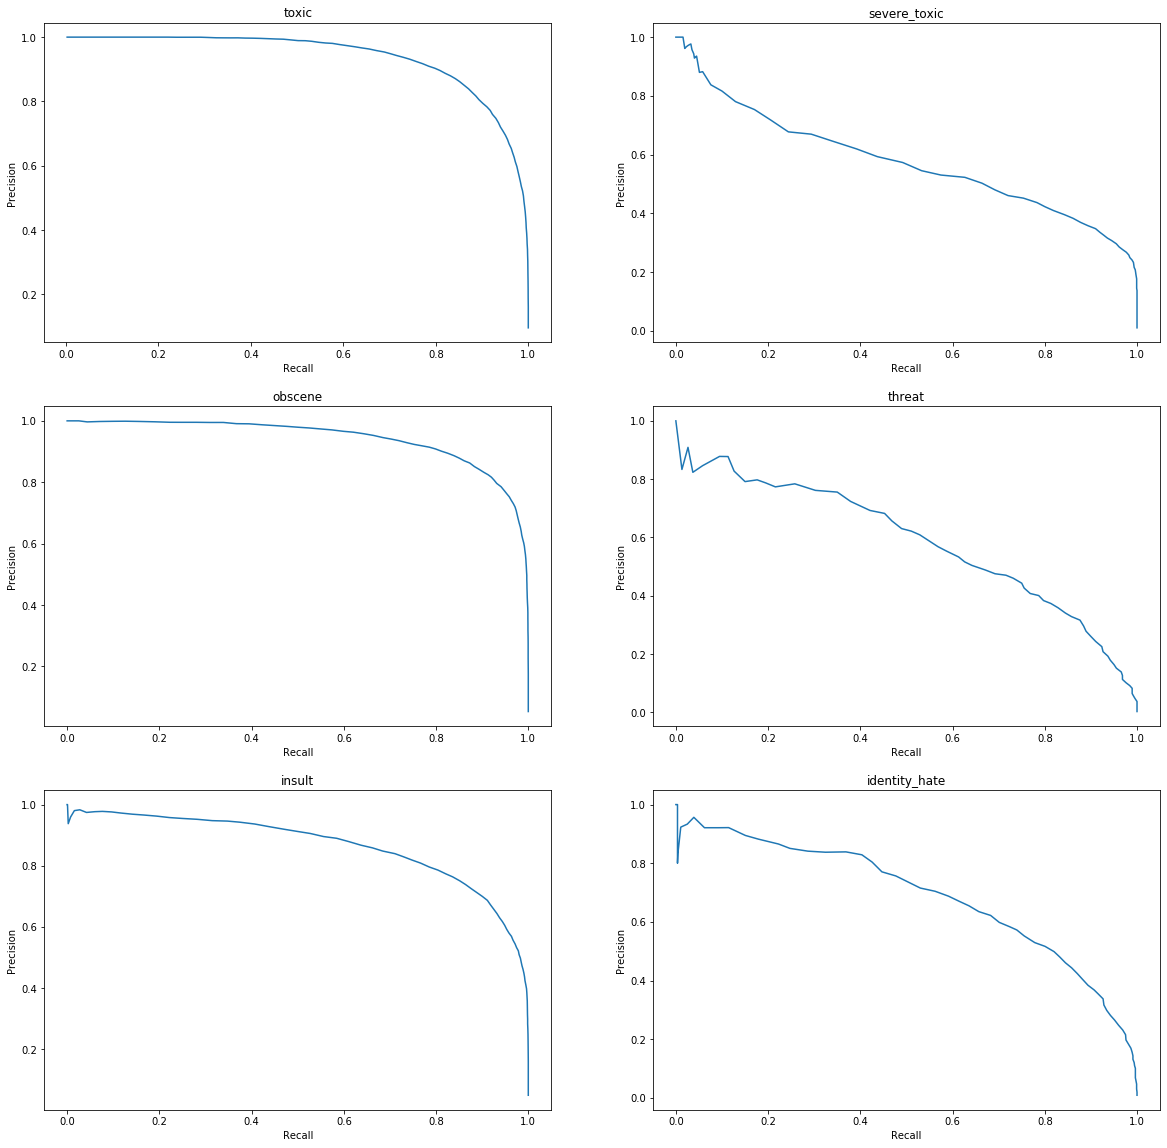

In [111]:
classes = train_set.columns[1:]
plt.figure(figsize=(20, 20))
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.plot(recalls[i], precisions[i])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(classes[i])
plt.show()

We can also take a look at per-class F1 scores.

In [112]:
f1scores = engine.evaluate_mean_F1_multiclass(dataloader)
f1scores

array([0.85651779, 0.57209613, 0.86781356, 0.57037944, 0.79815053,
       0.65088757])